# Modelo (instalação + roteamento ao longo do tempo)

$$
\begin{aligned}
\min_{y,\;z,\;x}\quad
& \underbrace{\sum_{j\in\mathcal J} c_j\,y_j}_{\text{instalação}}
\;+\;
\underbrace{\sum_{t\in\mathcal T}\sum_{(i,j)\in \mathcal E_t}
\big(e_{ij}(t)+\lambda\big)\, x_{ij}(t)}_{\text{energia + proxy de latência}}
\\[0.35em]
\text{s.a.}\quad
& z_{ij}(t) \le A_{ij}(t), 
&& \forall t\in\mathcal T,\ \forall (i,j)\in \mathcal E_t,
\\[0.25em]
& z_{ij}(t) \le y_i,\quad z_{ij}(t) \le y_j, 
&& \forall t\in\mathcal T,\ \forall (i,j)\in \mathcal E_t,\ i,j\in\mathcal J,
\\[0.25em]
& 0 \le x_{ij}(t) \le C_{ij}(t)\,z_{ij}(t),
&& \forall t\in\mathcal T,\ \forall (i,j)\in \mathcal E_t,
\\[0.25em]
& \sum_{j:\,(m,j)\in \mathcal E_t} x_{mj}(t)
  - \sum_{i:\,(i,m)\in \mathcal E_t} x_{im}(t)
  = b_{m,t},
&& \forall m\in\mathcal M,\ \forall t\in\mathcal T,
\\[0.25em]
& \sum_{j:\,(i,j)\in \mathcal E_t} x_{ij}(t)
  - \sum_{k:\,(k,i)\in \mathcal E_t} x_{ki}(t)
  = 0,
&& \forall i\in\mathcal J,\ \forall t\in\mathcal T,
\\[0.25em]
& \sum_{i:\,(i,s)\in \mathcal E_t} x_{is}(t)
  - \sum_{j:\,(s,j)\in \mathcal E_t} x_{sj}(t)
  = \sum_{m\in\mathcal M} b_{m,t},
&& \forall t\in\mathcal T,
\\[0.35em]
& y_j\in\{0,1\},\qquad z_{ij}(t)\in\{0,1\},\qquad x_{ij}(t)\ge 0.
\end{aligned}
$$

onde:

- $\mathcal T=\{1,\dots,T\}$ (tempos discretos), $\mathcal M=\{1,\dots,M\}$ (móveis), $\mathcal J=\{1,\dots,J\}$ (candidatos fixos) e $s$ é o **sink**;
- $V=\{s\}\,\dot\cup\,\mathcal J\,\dot\cup\,\mathcal M$;
- $p_i(t)\in\R^2$ é a posição do nó $i$ no tempo $t$: $p_s=\sigma$, $p_j=q_j\ (j\in\mathcal J)$, $p_m(t)=r_m(t)\ (m\in\mathcal M)$;
- $A_{ij}(t)=\mathbf{1}\{\|p_i(t)-p_j(t)\|\le R_c,\ i\neq j\}$ e $\mathcal E_t=\{(i,j)\in V\times V: A_{ij}(t)=1\}$;
- $C_{ij}(t)=\max\{0,\,C_0-k_{\text{decay}}\|p_i(t)-p_j(t)\|\}$;
- $e_{ij}(t)=\|p_i(t)-p_j(t)\|^2$ e $\lambda>0$ é a penalização linear (proxy de latência);
- $b_{m,t}=1$ (uma unidade gerada por móvel e por instante, como no exemplo).

Set parameter Username
Set parameter LicenseID to value 2717665
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1506 rows, 820 columns and 3154 nonzeros
Model fingerprint: 0x654eaf91
Variable types: 406 continuous, 414 integer (414 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 846.5754889
Presolve removed 969 rows and 399 columns
Presolve time: 0.03s
Presolved: 537 rows, 421 columns, 1566 nonzeros
Found heuristic solution: objective 816.7258062
Variable types: 344 continuous, 77 integer (77 binary)

Root relaxat

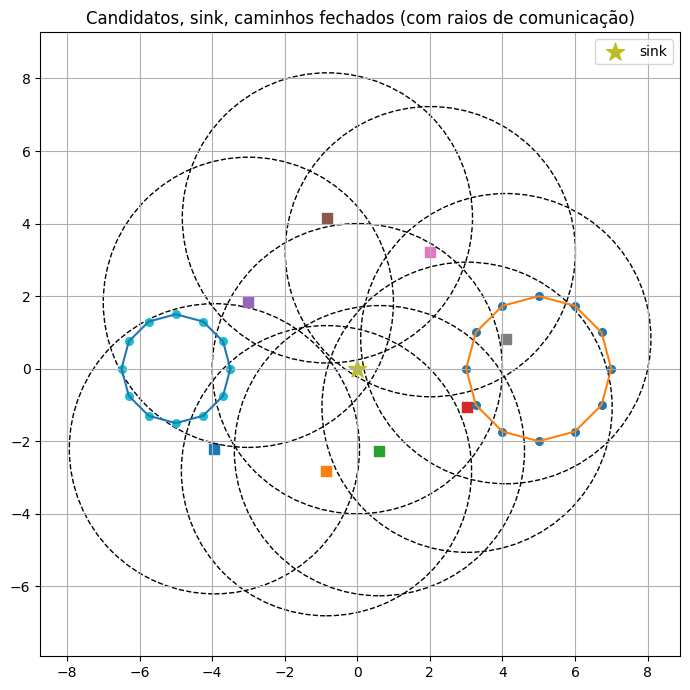

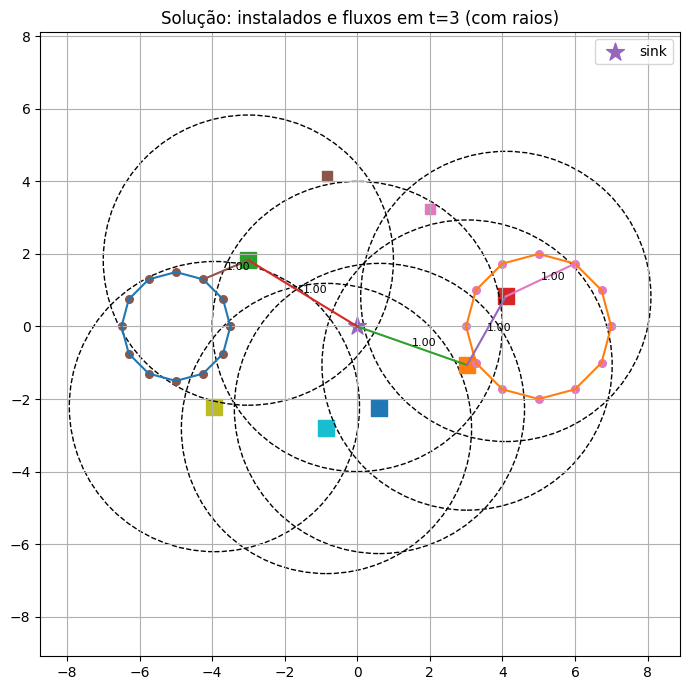

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

try:
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    raise RuntimeError(
        "Este script requer 'gurobipy'. Instale e garanta uma licença ativa do Gurobi."
    ) from e

# ---------------------------
# Parâmetros do exemplo
# ---------------------------
rng = np.random.default_rng(42)

T = 12                       # passos de tempo (loops mais suaves)
M_mobiles = 2               # móveis: {0,1}
F_max = 8                   # candidatos a fixos: {0..7}
R_comm = 4.0                # raio de comunicação
lambda_latency = 0.05       # penalização linear (proxy de latência)
t_plot = 3                  # snapshot para visualização

# Custo de instalação (uniforme no demo)
c_install_scalar = 1.0

# Parâmetros de capacidade e custo energético (iguais ao notebook anterior)
cap0, kdecay = 5.0, 0.5    # C_ij(t) = max(0, cap0 - kdecay * d_ij(t))
def energy_per_unit(d):     # e_ij(t) = ||d||^2
    return d**2

# ---------------------------
# Geometria dos nós
# ---------------------------
sink = ("sink",)
q_sink = np.array([0.0, 0.0])

F = [("f", j) for j in range(F_max)]
q_fixed = {}
grid_points = [
    (-4, -2), (-1, -3), (1, -2), (3, -1),
    (-3,  2), (-1,  4), (2,  3),  (4,  1)
]
for j, gpnt in enumerate(grid_points[:F_max]):
    jitter = rng.normal(scale=0.2, size=2)
    q_fixed[("f", j)] = np.array(gpnt, dtype=float) + jitter

# Trajetórias fechadas e disjuntas (círculos)
centers = [np.array([-5.0, 0.0]), np.array([ 5.0, 0.0])]
radii   = [1.5, 2.0]

def r_mobile(m, t):
    theta = 2*np.pi * (t-1) / T  # laço fechado (t=T+1 == t=1)
    return centers[m] + radii[m] * np.array([np.cos(theta), np.sin(theta)])

def pos_node(n, t):
    if n == sink:
        return q_sink
    if n[0] == "f":
        return q_fixed[n]
    if n[0] == "m":
        return r_mobile(n[1], t)
    raise ValueError("nó desconhecido")

# Demanda (fonte) por móvel e tempo
b = {(m, t): 1.0 for m in range(M_mobiles) for t in range(1, T+1)}

# ---------------------------
# Conjuntos por tempo e atributos de enlace
# ---------------------------
def link_possible(pi, pj): return np.linalg.norm(pi - pj) <= R_comm + 1e-9
def capacity(pi, pj):
    d = np.linalg.norm(pi - pj)
    return max(0.0, cap0 - kdecay * d)

E_t = {}                 # lista de arestas viáveis por t
A = {}                   # A_ij(t) ∈ {0,1}
C = {}                   # C_ij(t) ≥ 0
cost = {}                # (e_ij(t)+lambda) ≥ 0

for t in range(1, T+1):
    nodes_t = [sink] + F + [("m", m) for m in range(M_mobiles)]
    E_t[t] = []
    for i in nodes_t:
        for j in nodes_t:
            if i == j: 
                continue
            pi, pj = pos_node(i, t), pos_node(j, t)
            feas = link_possible(pi, pj)
            A[(i, j, t)] = 1 if feas else 0
            if feas:
                cap = capacity(pi, pj)
                if cap > 1e-9:
                    E_t[t].append((i, j))
                    C[(i, j, t)] = cap
                    d = np.linalg.norm(pi - pj)
                    cost[(i, j, t)] = energy_per_unit(d) + lambda_latency

# ---------------------------
# Modelo Gurobi
# ---------------------------
mdl = gp.Model("WSN_Placement_Routing")
mdl.Params.OutputFlag = 1  # ajuste se quiser silenciar

# Variáveis
y = {j: mdl.addVar(vtype=GRB.BINARY, name=f"y_{j[1]}") for j in F}
z = {}
x = {}
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        z[(i, j, t)] = mdl.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}_t{t}")
        x[(i, j, t)] = mdl.addVar(lb=0.0, name=f"x_{i}_{j}_t{t}")

mdl.update()

# Objetivo
obj_install = gp.quicksum(c_install_scalar * y[j] for j in F)
obj_flow    = gp.quicksum(cost[(i, j, t)] * x[(i, j, t)] for t in range(1, T+1) for (i, j) in E_t[t])
mdl.setObjective(obj_install + obj_flow, GRB.MINIMIZE)

# Restrições
# 1) Existência do enlace e instalação das extremidades fixas
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        mdl.addConstr(z[(i, j, t)] <= A[(i, j, t)], name=f"exist_{i}_{j}_t{t}")
        if i[0] == "f":
            mdl.addConstr(z[(i, j, t)] <= y[i], name=f"inst_i_{i}_{j}_t{t}")
        if j[0] == "f":
            mdl.addConstr(z[(i, j, t)] <= y[j], name=f"inst_j_{i}_{j}_t{t}")

# 2) Capacidade
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        mdl.addConstr(x[(i, j, t)] <= C[(i, j, t)] * z[(i, j, t)], name=f"cap_{i}_{j}_t{t}")

# 3) Conservação de fluxo
for t in range(1, T+1):
    # Móveis: fonte = b_{m,t}
    for m in range(M_mobiles):
        n = ("m", m)
        outflow = gp.quicksum(x[(n, j, t)] for (ii, j) in E_t[t] if ii == n)
        inflow  = gp.quicksum(x[(i, n, t)] for (i, jj) in E_t[t] if jj == n)
        mdl.addConstr(outflow - inflow == b[(m, t)], name=f"flow_mobile_m{m}_t{t}")

    # Fixos: balanço = 0 (mas só contam se instalados; modelado via z<=y nas arestas)
    for i in F:
        outflow = gp.quicksum(x[(i, j, t)] for (ii, j) in E_t[t] if ii == i)
        inflow  = gp.quicksum(x[(j, i, t)] for (j, jj) in E_t[t] if jj == i)
        mdl.addConstr(outflow - inflow == 0.0, name=f"flow_fixed_{i}_t{t}")

    # Sink: entra tudo que os móveis geram
    outflow_s = gp.quicksum(x[(sink, j, t)] for (i, j) in E_t[t] if i == sink)
    inflow_s  = gp.quicksum(x[(i, sink, t)] for (i, j) in E_t[t] if j == sink)
    total_bt  = sum(b[(m, t)] for m in range(M_mobiles))
    mdl.addConstr(inflow_s - outflow_s == total_bt, name=f"flow_sink_t{t}")

# Resolver
mdl.optimize()

# ---------------------------
# Extrair solução
# ---------------------------
status = mdl.Status
if status != GRB.OPTIMAL and status != GRB.SUBOPTIMAL:
    raise RuntimeError(f"Modelo não resolveu para ótimo/subótimo. Status Gurobi: {status}")

y_val = {j: y[j].X for j in F}
installed = [j for j, v in y_val.items() if v > 0.5]

x_val = {(i, j, t): x[(i, j, t)].X for t in range(1, T+1) for (i, j) in E_t[t]}
z_val = {(i, j, t): z[(i, j, t)].X for t in range(1, T+1) for (i, j) in E_t[t]}

# ---------------------------
# Fig 1: candidatos + loops + raios (sink e candidatos)
# ---------------------------
plt.figure(figsize=(7,7))
ax1 = plt.gca()

# candidatos + seus raios
for j in F:
    q = q_fixed[j]
    ax1.scatter([q[0]], [q[1]], marker='s', s=60)
    ax1.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# sink + raio
ax1.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax1.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# trajetórias fechadas
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax1.plot(traj[:,0], traj[:,1], linestyle='-')
    ax1.scatter(traj[:,0], traj[:,1], marker='o', s=30)

ax1.set_title("Candidatos, sink, caminhos fechados (com raios de comunicação)")
ax1.axis('equal'); ax1.grid(True); ax1.legend(); plt.tight_layout(); plt.show()

# ---------------------------
# Fig 2: solução (instalados + fluxos em t_plot) + raios (sink e instalados)
# ---------------------------
plt.figure(figsize=(7,7))
ax2 = plt.gca()

# todos candidatos (marcadores pequenos)
for j in F:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=60)

# instalados (marcadores maiores + raio)
for j in installed:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=120)
    ax2.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# sink + raio
ax2.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax2.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# trajetórias (para contexto)
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax2.plot(traj[:,0], traj[:,1], linestyle='-')
    ax2.scatter(traj[:,0], traj[:,1], marker='o', s=30)

# fluxos ativos no snapshot
flows_t = {(i, j): x_val[(i, j, t_plot)] for (i, j) in E_t[t_plot] if x_val[(i, j, t_plot)] > 1e-6}
for (i, j), val in flows_t.items():
    pi, pj = pos_node(i, t_plot), pos_node(j, t_plot)
    ax2.plot([pi[0], pj[0]], [pi[1], pj[1]])
    cx, cy = (pi[0]+pj[0])/2, (pi[1]+pj[1])/2
    ax2.text(cx, cy, f"{val:.2f}", fontsize=8)

ax2.set_title(f"Solução: instalados e fluxos em t={t_plot} (com raios)")
ax2.axis('equal'); ax2.grid(True); ax2.legend(); plt.tight_layout(); plt.show()


## (Opcional) Decomposição por enumeração de $Y$ e LP por instante

Se preferir evitar binários em $z$ e $y$, pode-se enumerar $Y\subseteq\mathcal J$ (nós fixos instalados) e resolver um **LP** por tempo $t$, somando os ótimos e adicionando o custo de instalação.

**LP por instante $t$ (dado $Y$)**:
$$
\begin{aligned}
\min_{x(\cdot,t)}\quad
& \sum_{(i,j)\in \mathcal E_t(Y)} \big(e_{ij}(t)+\lambda\big)\, x_{ij}(t) \\[0.25em]
\text{s.a.}\quad
& 0 \le x_{ij}(t) \le C_{ij}(t),
&& \forall (i,j)\in \mathcal E_t(Y), \\[0.25em]
& \sum_{j:\,(m,j)\in \mathcal E_t(Y)} x_{mj}(t)
  - \sum_{i:\,(i,m)\in \mathcal E_t(Y)} x_{im}(t)
  = b_{m,t},
&& \forall m\in\mathcal M, \\[0.25em]
& \sum_{j:\,(i,j)\in \mathcal E_t(Y)} x_{ij}(t)
  - \sum_{k:\,(k,i)\in \mathcal E_t(Y)} x_{ki}(t)
  = 0,
&& \forall i\in Y, \\[0.25em]
& \sum_{i:\,(i,s)\in \mathcal E_t(Y)} x_{is}(t)
  - \sum_{j:\,(s,j)\in \mathcal E_t(Y)} x_{sj}(t)
  = \sum_{m\in\mathcal M} b_{m,t},
\end{aligned}
$$

em que
$$
\mathcal E_t(Y)=\big\{(i,j)\in V(Y)\times V(Y): A_{ij}(t)=1\big\},
\quad
V(Y)=\{s\}\cup Y\cup \mathcal M.
$$
O custo total do caso $Y$ é $\sum_{t\in\mathcal T}\text{LP}_t(Y)+\sum_{j\in Y}c_j$.  
Escolhe-se $Y$ de menor custo total.

---

# Definições geométricas e de enlaces (como no código)

- **Posições**:
  $$
  p_s=\sigma=(0,0),\qquad
  q_j\in\R^2\ (j\in\mathcal J),\qquad
  r_m(t)\in\R^2\ (m\in\mathcal M,\ t\in\mathcal T).
  $$
  No exemplo, os $r_m(t)$ percorrem **loops fechados e disjuntos**:
  $$
  r_m(t)=c_m + \rho_m\,[\cos\theta_t,\ \sin\theta_t],\quad
  \theta_t=\tfrac{2\pi (t-1)}{T},
  $$
  com $c_1=(-5,0),\ \rho_1=1.5$ e $c_2=(5,0),\ \rho_2=2.0$.

- **Viabilidade de enlace** (raio de comunicação $R_c$):
  $$
  A_{ij}(t)=\mathbf 1\!\left\{\, \|p_i(t)-p_j(t)\|\le R_c\, \right\},
  \qquad R_c=\texttt{R\_comm}=4.0.
  $$

- **Capacidade** (linear decrescente com a distância):
  $$
  C_{ij}(t)=\max\{0,\ \underbrace{C_0}_{=5.0}\ -\ \underbrace{k_{\text{decay}}}_{=0.5}\,\|p_i(t)-p_j(t)\|\}.
  $$

- **Custo por unidade de fluxo** (energia + penalização linear):
  $$
  e_{ij}(t)+\lambda
  \;=\; \|p_i(t)-p_j(t)\|^2\ +\ \underbrace{\lambda}_{=0.05}.
  $$

- **Demanda** (cada móvel gera 1 por instante):
  $$
  b_{m,t}=1,\qquad \forall m\in\mathcal M,\ \forall t\in\mathcal T.
  $$

- **Custo de instalação** (uniforme no exemplo):
  $$
  c_j=1,\qquad \forall j\in\mathcal J.
  $$

---

## Observações de implementação

- **MILP único (recomendado no notebook)**: modele $y,z,x$ e resolva com Gurobi (como no script).
- **Alternativa por enumeração**: para $J=8$, é viável enumerar $Y\subseteq\mathcal J$ ($2^8$ casos) e resolver LPs; útil como verificação.
- Em ambos os casos, $\mathcal E_t$ é construída a partir de $A_{ij}(t)$; se $i$ ou $j$ forem fixos não instalados, o enlace é inativado (via $z\le y$ no MILP ou retirando o nó em $V(Y)$ na enumeração).

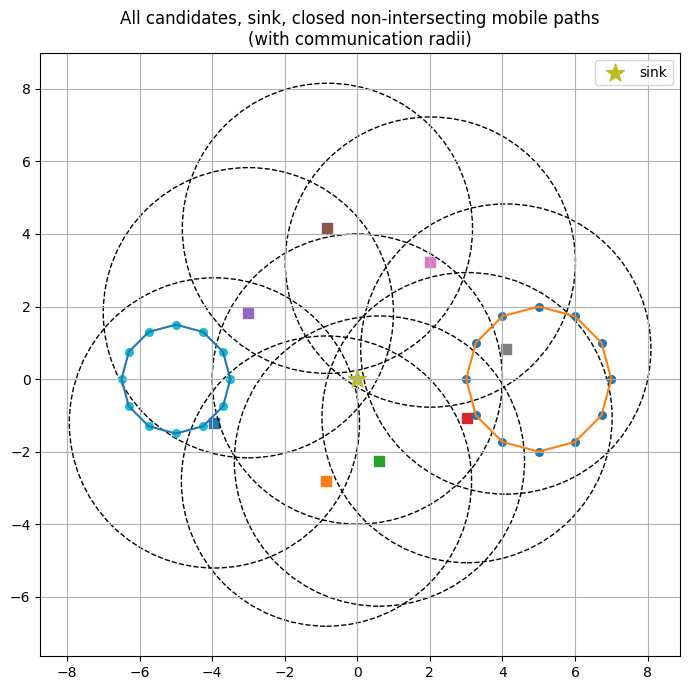

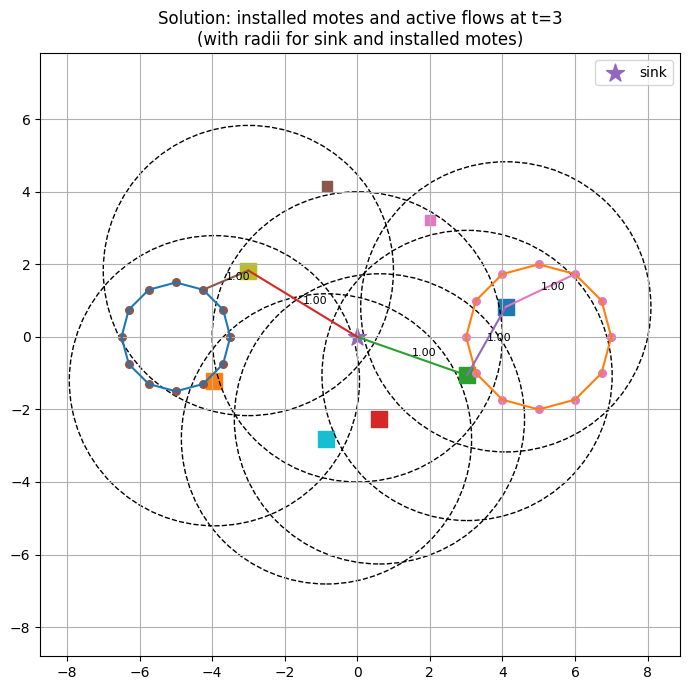

In [2]:
# Solver: enumeration over installs + per-time min-cost flow LP (scipy.linprog).
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from itertools import product
from scipy.optimize import linprog

rng = np.random.default_rng(42)

# ---------------------------
# Problem data
# ---------------------------
T = 12              
M_mobiles = 2
F_max = 8
R_comm = 4.0
lambda_latency = 0.05

sink = ("sink",)
q_sink = np.array([0.0, 0.0])

F = [("f", j) for j in range(F_max)]
q_fixed = {}
grid_points = [
    (-4, -1), (-1, -3), (1, -2), (3, -1),
    (-3,  2), (-1,  4), (2,  3),  (4,  1)
]
for j, gpnt in enumerate(grid_points[:F_max]):
    jitter = rng.normal(scale=0.2, size=2)
    q_fixed[("f", j)] = np.array(gpnt, dtype=float) + jitter

# ---------------------------
# Closed, non-intersecting mobile trajectories
# ---------------------------
centers = [np.array([-5.0, 0.0]), np.array([5.0, 0.0])]
radii   = [1.5, 2.0]

def r_mobile(m, t):
    theta = 2*np.pi * (t-1) / T  # ensures closed loop (t=T+1 equals t=1)
    center = centers[m]
    rad = radii[m]
    return center + rad * np.array([np.cos(theta), np.sin(theta)])

# demand per mobile/time
b = {(m, t): 1.0 for m in range(M_mobiles) for t in range(1, T+1)}

def link_possible(pi, pj):
    return np.linalg.norm(pi - pj) <= R_comm + 1e-9

def capacity(pi, pj):
    d = np.linalg.norm(pi - pj)
    cap0, k = 5.0, 0.5
    return max(0.0, cap0 - k*d)

def energy_per_unit(pi, pj):
    d = np.linalg.norm(pi - pj)
    return d**2

c_install = {j: 1.0 for j in F}

def pos_node(n, t):
    if n == sink:
        return q_sink
    if n[0] == "f":
        return q_fixed[n]
    if n[0] == "m":
        return r_mobile(n[1], t)
    raise ValueError("Unknown node")

def build_edges_for_time(t):
    nodes_t = [sink] + F + [("m", m) for m in range(M_mobiles)]
    E = []
    C = {}
    Ecost = {}
    for i in nodes_t:
        for j in nodes_t:
            if i == j:
                continue
            pi, pj = pos_node(i, t), pos_node(j, t)
            if link_possible(pi, pj):
                cap = capacity(pi, pj)
                if cap > 1e-8:
                    E.append((i, j))
                    C[(i, j)] = cap
                    Ecost[(i, j)] = energy_per_unit(pi, pj) + lambda_latency
    return nodes_t, E, C, Ecost

def solve_for_install(Y):
    total_obj = sum(c_install[j] for j in Y)
    flows_per_time = {}
    for t in range(1, T+1):
        nodes_t, E, C, Ecost = build_edges_for_time(t)
        E_use = []
        for (i, j) in E:
            if (i[0] == "f" and i not in Y): 
                continue
            if (j[0] == "f" and j not in Y): 
                continue
            E_use.append((i, j))
        if not E_use:
            return None, None
        
        edge_index = {e: k for k, e in enumerate(E_use)}
        nvar = len(E_use)
        c = np.array([Ecost[e] for e in E_use], dtype=float)
        bounds = [(0.0, C[e]) for e in E_use]
        
        node_list = [sink] + F + [("m", m) for m in range(M_mobiles)]
        node_list = [n for n in node_list if not (n[0]=="f" and n not in Y)]
        
        A_eq = np.zeros((len(node_list), nvar), dtype=float)
        b_eq = np.zeros((len(node_list),), dtype=float)
        
        total_b_t = sum(b[(m, t)] for m in range(M_mobiles))
        for r, n in enumerate(node_list):
            if n[0] == "m":
                b_eq[r] = b[(n[1], t)]
            elif n == sink:
                b_eq[r] = -total_b_t
            else:
                b_eq[r] = 0.0
        
        for e, k in edge_index.items():
            i, j = e
            if i in node_list:
                A_eq[node_list.index(i), k] += 1.0
            if j in node_list:
                A_eq[node_list.index(j), k] -= 1.0
        
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        if (not res.success) or res.status != 0:
            return None, None
        
        x_sol = res.x
        flows = {e: x_sol[k] for e, k in edge_index.items() if x_sol[k] > 1e-9}
        flows_per_time[t] = flows
        total_obj += res.fun
    
    return total_obj, flows_per_time

# Enumerate installs
best_obj = np.inf
best_Y = None
best_flows = None

for bits in product([0,1], repeat=F_max):
    Y = {("f", j) for j,bv in enumerate(bits) if bv==1}
    obj, flows = solve_for_install(Y)
    if obj is not None and obj < best_obj:
        best_obj = obj
        best_Y = Y
        best_flows = flows
        
# ---------------------------
# Figure 1: candidates + full closed mobile loops + radii
# ---------------------------
fig1 = plt.figure(figsize=(7,7))
ax1 = plt.gca()

# Candidate fixed + their radii
for j in F:
    q = q_fixed[j]
    ax1.scatter([q[0]], [q[1]], marker='s', s=60)
    ax1.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Sink + radius
ax1.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax1.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Closed trajectories
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax1.plot(traj[:,0], traj[:,1], linestyle='-')
    ax1.scatter(traj[:,0], traj[:,1], marker='o', s=30)

ax1.set_title("All candidates, sink, closed non-intersecting mobile paths\n(with communication radii)")
ax1.axis('equal')
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# Figure 2: solution at snapshot with radii for sink + installed
# ---------------------------
t_plot = 3
fig2 = plt.figure(figsize=(7,7))
ax2 = plt.gca()

# All candidates (faint)
for j in F:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=60)

# Installed motes + their radii
for j in best_Y:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=120)
    ax2.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Sink + radius
ax2.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax2.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Closed trajectories
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax2.plot(traj[:,0], traj[:,1], linestyle='-')
    ax2.scatter(traj[:,0], traj[:,1], marker='o', s=30)
    
# Active flows at t_plot
flows_t = best_flows[t_plot]
for (i, j), val in flows_t.items():
    if (i[0]=="f" and i not in best_Y) or (j[0]=="f" and j not in best_Y):
        continue
    pi, pj = pos_node(i, t_plot), pos_node(j, t_plot)
    ax2.plot([pi[0], pj[0]], [pi[1], pj[1]])
    cx, cy = (pi[0]+pj[0])/2, (pi[1]+pj[1])/2
    ax2.text(cx, cy, f"{val:.2f}", fontsize=8)

ax2.set_title(f"Solution: installed motes and active flows at t={t_plot}\n(with radii for sink and installed motes)")
ax2.axis('equal')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

## Expansão Estrutural

Para refinar o modelo e incorporar aspectos de comunicação mais realistas, introduzimos agora:
- um **raio de interferência** $R_i > R_c$, definindo a região na qual dois enlaces simultâneos causam interferência;
- um esquema **TDMA (Time Division Multiple Access)** com um conjunto finito de slots de transmissão $\mathcal S = \{1,\dots,S\}$ para cada instante de tempo $t$.


Assim, cada enlace $(i,j)$, em cada instante $t$ e slot $s$, é representado pelas variáveis:
$$
z_{ij}(t,s)\in\{0,1\}, \quad x_{ij}(t,s)\ge 0,
$$
onde $z_{ij}(t,s)=1$ indica que o enlace $(i,j)$ está ativo no slot $s$ e $x_{ij}(t,s)$ é o fluxo de dados correspondente.

O conjunto de enlaces viáveis passa a depender tanto da distância quanto da interferência:
$$
\mathcal E_t = \big\{(i,j)\in V\times V:\|p_i(t)-p_j(t)\|\le R_c,\ i\neq j\big\},
$$
e definimos a matriz de interferência entre enlaces
$$
I_{(i,j),(k,l)}(t) =
\begin{cases}
1, & \text{se } (i,j)\neq(k,l)\ \text{e}\ 
\min\{\|p_i(t)-p_k(t)\|,\|p_j(t)-p_l(t)\|\}<R_i,\\[0.25em]
0, & \text{caso contrário.}
\end{cases}
$$

### Modelo MILP com TDMA e interferência

O modelo estendido é dado por:

$$
\begin{aligned}
\min_{y,z,x}\quad
& \sum_{j\in\mathcal J} c_j\,y_j
+ \sum_{t\in\mathcal T}\sum_{s\in\mathcal S}
  \sum_{(i,j)\in \mathcal E_t}
  \big(e_{ij}(t)+\lambda\big)\, x_{ij}(t,s)
\\[0.4em]
\text{s.a.}\quad
& z_{ij}(t,s)\le A_{ij}(t),
&& \forall (i,j)\in\mathcal E_t,\ \forall t,s,
\\[0.25em]
& z_{ij}(t,s)\le y_i,\quad z_{ij}(t,s)\le y_j,
&& \forall (i,j)\in\mathcal E_t,\ i,j\in\mathcal J,\ \forall t,s,
\\[0.25em]
& 0\le x_{ij}(t,s)\le C_{ij}(t)\,z_{ij}(t,s),
&& \forall (i,j)\in\mathcal E_t,\ \forall t,s,
\\[0.25em]
& \sum_{(k,l)\in\mathcal E_t} I_{(i,j),(k,l)}(t)\,z_{kl}(t,s)\le 1,
&& \forall (i,j)\in\mathcal E_t,\ \forall t,s,
\\[0.25em]
& \sum_{s\in\mathcal S}\sum_{j:(m,j)\in \mathcal E_t} x_{mj}(t,s)
  - \sum_{s\in\mathcal S}\sum_{i:(i,m)\in \mathcal E_t} x_{im}(t,s)
  = b_{m,t},
&& \forall m\in\mathcal M,\ \forall t,
\\[0.25em]
& \sum_{s\in\mathcal S}\sum_{j:(i,j)\in \mathcal E_t} x_{ij}(t,s)
  - \sum_{s\in\mathcal S}\sum_{k:(k,i)\in \mathcal E_t} x_{ki}(t,s)
  = 0,
&& \forall i\in\mathcal J,\ \forall t,
\\[0.25em]
& \sum_{s\in\mathcal S}\sum_{i:(i,\sigma)\in \mathcal E_t} x_{i\sigma}(t,s)
  - \sum_{s\in\mathcal S}\sum_{j:(\sigma,j)\in \mathcal E_t} x_{\sigma j}(t,s)
  = \sum_{m\in\mathcal M} b_{m,t},
&& \forall t,
\\[0.25em]
& y_j\in\{0,1\},\quad z_{ij}(t,s)\in\{0,1\},\quad x_{ij}(t,s)\ge 0.
\end{aligned}
$$

### Interpretação

- A restrição de **interferência** assegura que, em cada slot $s$, nenhum enlace ativo esteja dentro do raio de interferência de outro. Isso limita a reutilização espacial de canais e aproxima o modelo de sistemas TDMA reais.
- O termo $\sum_{s\in\mathcal S}$ nas equações de fluxo garante a **conservação de dados agregada** por tempo $t$, mesmo com divisão de slots.
- O número de slots $|\mathcal S|$ controla a **capacidade de paralelismo**: quanto maior $S$, maior a taxa agregada possível (à custa de maior complexidade).

### Considerações computacionais

O modelo permanece um **MILP** (linear em todas as variáveis), porém seu tamanho cresce linearmente com o número de slots $S$ e quadraticamente com o número de enlaces (devido à matriz de interferência $I_{(i,j),(k,l)}$).  
Essa formulação é apropriada para resolver instâncias pequenas ou médias e serve como base para futuras estratégias de decomposição (por exemplo, relaxações lagrangeanas por slot).

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 63084 rows, 6888 columns and 129344 nonzeros
Model fingerprint: 0x066840ce
Variable types: 3440 continuous, 3448 integer (3448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 57992 rows and 2 columns
Presolve time: 0.58s
Presolved: 5092 rows, 6886 columns, 33160 nonzeros
Variable types: 3440 continuous, 3446 integer (3446 binary)

Root relaxation: objective 4.393475e+02, 774 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

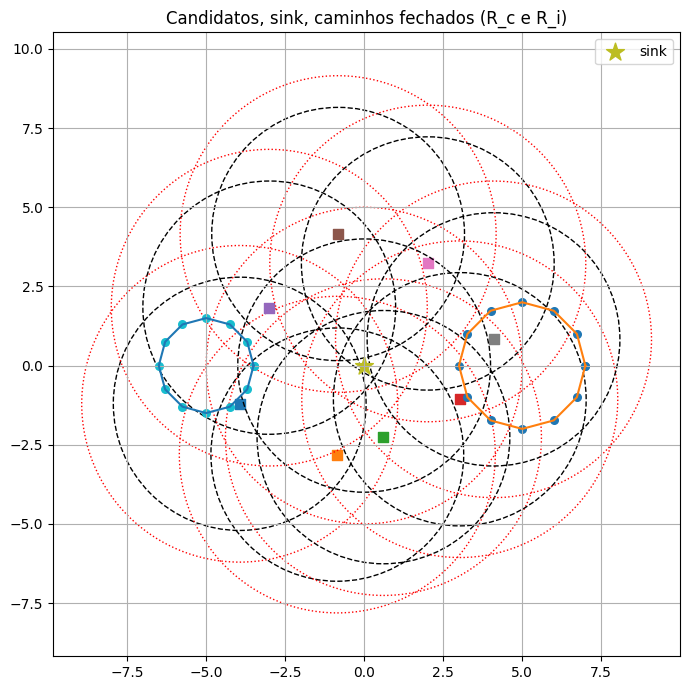

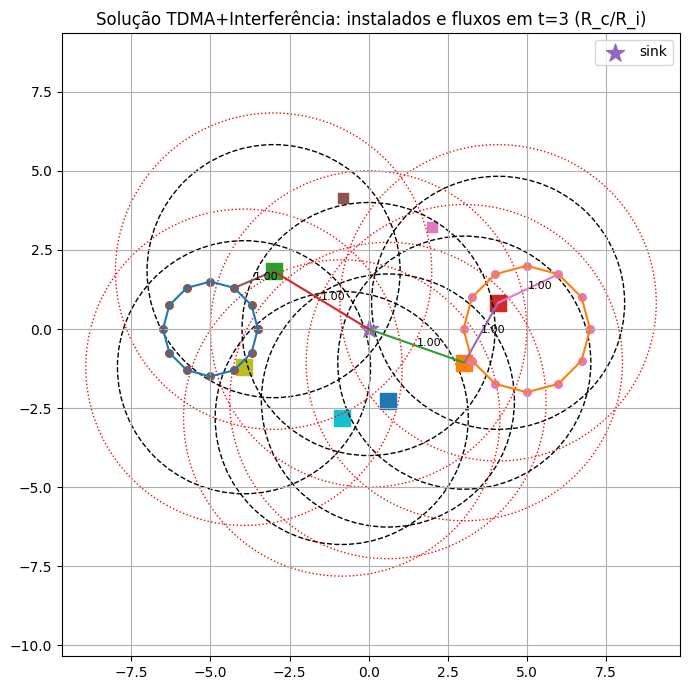

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

try:
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    raise RuntimeError(
        "Este script requer 'gurobipy'. Instale e garanta uma licença ativa do Gurobi."
    ) from e

# ---------------------------
# Parâmetros do exemplo
# ---------------------------
rng = np.random.default_rng(42)

T = 12                        # passos de tempo (loops mais suaves)
M_mobiles = 2                 # móveis: {0,1}
F_max = 8                     # candidatos a fixos: {0..7}
R_comm = 4.0                  # raio de comunicação (R_c)
R_interf = 5.0                # raio de interferência (R_i > R_c)
S_slots = 8                   # número de slots TDMA por instante
lambda_latency = 0.05         # penalização linear (proxy de latência)
t_plot = 3                    # snapshot para visualização

# Custo de instalação (uniforme no demo)
c_install_scalar = 1.0

# Parâmetros de capacidade e custo energético (iguais ao notebook anterior)
cap0, kdecay = 5.0, 0.5       # C_ij(t) = max(0, cap0 - kdecay * d_ij(t))
def energy_per_unit(d):       # e_ij(t) = ||d||^2
    return d**2

# ---------------------------
# Geometria dos nós
# ---------------------------
sink = ("sink",)
q_sink = np.array([0.0, 0.0])

F = [("f", j) for j in range(F_max)]
q_fixed = {}
grid_points = [
    (-4, -1), (-1, -3), (1, -2), (3, -1),
    (-3,  2), (-1,  4), (2,  3),  (4,  1)
]
for j, gpnt in enumerate(grid_points[:F_max]):
    jitter = rng.normal(scale=0.2, size=2)
    q_fixed[("f", j)] = np.array(gpnt, dtype=float) + jitter

# Trajetórias fechadas e disjuntas (círculos)
centers = [np.array([-5.0, 0.0]), np.array([ 5.0, 0.0])]
radii   = [1.5, 2.0]

def r_mobile(m, t):
    theta = 2*np.pi * (t-1) / T  # laço fechado (t=T+1 == t=1)
    return centers[m] + radii[m] * np.array([np.cos(theta), np.sin(theta)])

def pos_node(n, t):
    if n == sink:
        return q_sink
    if n[0] == "f":
        return q_fixed[n]
    if n[0] == "m":
        return r_mobile(n[1], t)
    raise ValueError("nó desconhecido")

# Demanda (fonte) por móvel e tempo
b = {(m, t): 1.0 for m in range(M_mobiles) for t in range(1, T+1)}

# ---------------------------
# Conjuntos por tempo e atributos de enlace
# ---------------------------
def link_possible(pi, pj): 
    return np.linalg.norm(pi - pj) <= R_comm + 1e-9

def capacity(pi, pj):
    d = np.linalg.norm(pi - pj)
    return max(0.0, cap0 - kdecay * d)

def link_cost(pi, pj):
    d = np.linalg.norm(pi - pj)
    return energy_per_unit(d) + lambda_latency

def interferes(pi, pj, pk, pl):
    """
    Critério simples e simétrico de interferência com raio R_interf:
    Dois enlaces (i->j) e (k->l) conflitam se compartilham um nó
    OU se qualquer par de extremidades está a < R_interf.
    """
    if (np.allclose(pi, pk) and np.allclose(pj, pl)) or (np.allclose(pi, pl) and np.allclose(pj, pk)):
        return False  # é o mesmo enlace (ou reverso); trataremos pares distintos acima
    # Compartilha nó (mesmo índice de nó) será checado fora via tuplas; aqui usamos posições como fallback
    d_pairs = [
        np.linalg.norm(pi - pk),
        np.linalg.norm(pi - pl),
        np.linalg.norm(pj - pk),
        np.linalg.norm(pj - pl),
    ]
    return (min(d_pairs) < R_interf - 1e-9)

E_t = {}                 # lista de arestas viáveis por t
A = {}                   # A_ij(t) ∈ {0,1}
C = {}                   # C_ij(t) ≥ 0
cost = {}                # (e_ij(t)+lambda) ≥ 0
conflict_pairs = {}      # por t: lista de pares ((i,j),(k,l)) que conflitam

for t in range(1, T+1):
    nodes_t = [sink] + F + [("m", m) for m in range(M_mobiles)]
    E_t[t] = []
    # Construção de enlaces viáveis
    for i in nodes_t:
        for j in nodes_t:
            if i == j:
                continue
            pi, pj = pos_node(i, t), pos_node(j, t)
            feas = link_possible(pi, pj)
            A[(i, j, t)] = 1 if feas else 0
            if feas:
                cap = capacity(pi, pj)
                if cap > 1e-9:
                    E_t[t].append((i, j))
                    C[(i, j, t)] = cap
                    cost[(i, j, t)] = link_cost(pi, pj)

    # Pares de conflito por interferência (simétrica)
    conflict_pairs[t] = []
    Elist = E_t[t]
    for idx1 in range(len(Elist)):
        (i, j) = Elist[idx1]
        pi, pj = pos_node(i, t), pos_node(j, t)
        for idx2 in range(idx1 + 1, len(Elist)):
            (k, l) = Elist[idx2]
            # Se compartilham nó, conflitam (não podem ser simultâneos no mesmo slot)
            share_node = (i == k) or (i == l) or (j == k) or (j == l)
            if share_node:
                conflict_pairs[t].append(((i, j), (k, l)))
                continue
            pk, pl = pos_node(k, t), pos_node(l, t)
            if interferes(pi, pj, pk, pl):
                conflict_pairs[t].append(((i, j), (k, l)))

# ---------------------------
# Modelo Gurobi (com TDMA e interferência)
# ---------------------------
mdl = gp.Model("WSN_Placement_Routing_TDMA_Interference")
mdl.Params.OutputFlag = 1  # 0 para silenciar

# Variáveis
y = {j: mdl.addVar(vtype=GRB.BINARY, name=f"y_{j[1]}") for j in F}
z = {}  # z[(i,j,t,s)]
x = {}  # x[(i,j,t,s)]
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        for s in range(1, S_slots+1):
            z[(i, j, t, s)] = mdl.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}_t{t}_s{s}")
            x[(i, j, t, s)] = mdl.addVar(lb=0.0, name=f"x_{i}_{j}_t{t}_s{s}")

mdl.update()

# Objetivo: instalação + fluxo agregado (soma nos slots)
obj_install = gp.quicksum(c_install_scalar * y[j] for j in F)
obj_flow = gp.quicksum(
    cost[(i, j, t)] * x[(i, j, t, s)]
    for t in range(1, T+1)
    for (i, j) in E_t[t]
    for s in range(1, S_slots+1)
)
mdl.setObjective(obj_install + obj_flow, GRB.MINIMIZE)

# Restrições
# 1) Existência do enlace e instalação das extremidades fixas (por slot)
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        for s in range(1, S_slots+1):
            mdl.addConstr(z[(i, j, t, s)] <= A[(i, j, t)], name=f"exist_{i}_{j}_t{t}_s{s}")
            if i[0] == "f":
                mdl.addConstr(z[(i, j, t, s)] <= y[i], name=f"inst_i_{i}_{j}_t{t}_s{s}")
            if j[0] == "f":
                mdl.addConstr(z[(i, j, t, s)] <= y[j], name=f"inst_j_{i}_{j}_t{t}_s{s}")

# 2) Capacidade por slot
for t in range(1, T+1):
    for (i, j) in E_t[t]:
        for s in range(1, S_slots+1):
            mdl.addConstr(x[(i, j, t, s)] <= C[(i, j, t)] * z[(i, j, t, s)],
                          name=f"cap_{i}_{j}_t{t}_s{s}")

# 3) Interferência por slot: pares conflitantes não podem estar ativos juntos
for t in range(1, T+1):
    for ((i, j), (k, l)) in conflict_pairs[t]:
        for s in range(1, S_slots+1):
            mdl.addConstr(z[(i, j, t, s)] + z[(k, l, t, s)] <= 1,
                          name=f"interf_{i}_{j}__{k}_{l}_t{t}_s{s}")

# 4) Conservação de fluxo (agregado nos slots)
for t in range(1, T+1):
    # Móveis: fonte = b_{m,t}
    for m in range(M_mobiles):
        n = ("m", m)
        outflow = gp.quicksum(x[(n, j, t, s)] for (ii, j) in E_t[t] if ii == n for s in range(1, S_slots+1))
        inflow  = gp.quicksum(x[(i, n, t, s)] for (i, jj) in E_t[t] if jj == n for s in range(1, S_slots+1))
        mdl.addConstr(outflow - inflow == b[(m, t)], name=f"flow_mobile_m{m}_t{t}")

    # Fixos: balanço = 0 (conta se instalado via z<=y nas arestas)
    for i in F:
        outflow = gp.quicksum(x[(i, j, t, s)] for (ii, j) in E_t[t] if ii == i for s in range(1, S_slots+1))
        inflow  = gp.quicksum(x[(j, i, t, s)] for (j, jj) in E_t[t] if jj == i for s in range(1, S_slots+1))
        mdl.addConstr(outflow - inflow == 0.0, name=f"flow_fixed_{i}_t{t}")

    # Sink: entra tudo que os móveis geram
    outflow_s = gp.quicksum(x[(sink, j, t, s)] for (i, j) in E_t[t] if i == sink for s in range(1, S_slots+1))
    inflow_s  = gp.quicksum(x[(i, sink, t, s)] for (i, j) in E_t[t] if j == sink for s in range(1, S_slots+1))
    total_bt  = sum(b[(m, t)] for m in range(M_mobiles))
    mdl.addConstr(inflow_s - outflow_s == total_bt, name=f"flow_sink_t{t}")

# Resolver
mdl.optimize()

# ---------------------------
# Extrair solução
# ---------------------------
status = mdl.Status
if status != GRB.OPTIMAL and status != GRB.SUBOPTIMAL:
    raise RuntimeError(f"Modelo não resolveu para ótimo/subótimo. Status Gurobi: {status}")

y_val = {j: y[j].X for j in F}
installed = [j for j, v in y_val.items() if v > 0.5]

x_val = {(i, j, t, s): x[(i, j, t, s)].X for t in range(1, T+1) for (i, j) in E_t[t] for s in range(1, S_slots+1)}
z_val = {(i, j, t, s): z[(i, j, t, s)].X for t in range(1, T+1) for (i, j) in E_t[t] for s in range(1, S_slots+1)}

# ---------------------------
# Fig 1: candidatos + loops + raios (sink e candidatos)
# ---------------------------
plt.figure(figsize=(7,7))
ax1 = plt.gca()

# candidatos + seus raios (comunicação e interferência)
for j in F:
    q = q_fixed[j]
    ax1.scatter([q[0]], [q[1]], marker='s', s=60)
    ax1.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))
    ax1.add_patch(Circle((q[0], q[1]), R_interf, fill=False, linewidth=1, ls=':', edgecolor='r'))

# sink + raios
ax1.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax1.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))
ax1.add_patch(Circle((q_sink[0], q_sink[1]), R_interf, fill=False, linewidth=1, ls=':', edgecolor='r'))

# trajetórias fechadas
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax1.plot(traj[:,0], traj[:,1], linestyle='-')
    ax1.scatter(traj[:,0], traj[:,1], marker='o', s=30)

ax1.set_title("Candidatos, sink, caminhos fechados (R_c e R_i)")
ax1.axis('equal'); ax1.grid(True); ax1.legend(); plt.tight_layout(); plt.show()

# ---------------------------
# Fig 2: solução (instalados + fluxos em t_plot) + raios (sink e instalados)
# ---------------------------
plt.figure(figsize=(7,7))
ax2 = plt.gca()

# todos candidatos (marcadores pequenos)
for j in F:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=60)

# instalados (marcadores maiores + raios)
for j in installed:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=120)
    ax2.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))
    ax2.add_patch(Circle((q[0], q[1]), R_interf, fill=False, linewidth=1, ls=':', edgecolor='r'))

# sink + raios
ax2.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax2.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))
ax2.add_patch(Circle((q_sink[0], q_sink[1]), R_interf, fill=False, linewidth=1, ls=':', edgecolor='r'))

# trajetórias (para contexto)
for m in range(M_mobiles):
    traj = np.array([r_mobile(m, t) for t in range(1, T+1)] + [r_mobile(m, 1)])
    ax2.plot(traj[:,0], traj[:,1], linestyle='-')
    ax2.scatter(traj[:,0], traj[:,1], marker='o', s=30)

# fluxos ativos no snapshot (agregados pelos slots)
flows_t = {}
for (i, j) in E_t[t_plot]:
    val = sum(x_val[(i, j, t_plot, s)] for s in range(1, S_slots+1))
    if val > 1e-6:
        flows_t[(i, j)] = val

for (i, j), val in flows_t.items():
    pi, pj = pos_node(i, t_plot), pos_node(j, t_plot)
    ax2.plot([pi[0], pj[0]], [pi[1], pj[1]])
    cx, cy = (pi[0]+pj[0])/2, (pi[1]+pj[1])/2
    ax2.text(cx, cy, f"{val:.2f}", fontsize=8)

ax2.set_title(f"Solução TDMA+Interferência: instalados e fluxos em t={t_plot} (R_c/R_i)")
ax2.axis('equal'); ax2.grid(True); ax2.legend(); plt.tight_layout(); plt.show()
